## CS441: Applied ML - HW 4

### Part 1: Model Complexity and Tree-based Regressors

One measure of a tree’s complexity is the maximum tree depth. Train tree, random forest, and boosted tree regressors on the temperature regression task, using all default parameters except:


*   max_depth={2,4,8,16,32}
*   random_state=0
*   For random forest: max_features=1/3

Measure train and val RMSE for each and plot them all on the same plot using the provided plot_depth_error function. You should have six lines (train/val for each model type), each with 5 data points (one for each max depth value).  Include the plot and answer the analysis questions in the report.

In [1]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/CS441/24FA/hw1/"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

Mounted at /content/drive


In [2]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure()
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

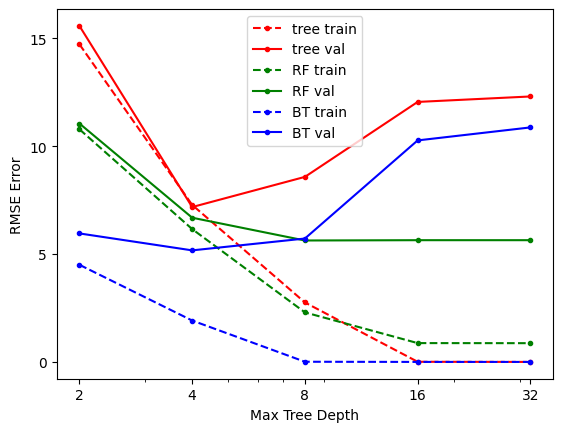

In [3]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

max_depths = [2,4,8,16,32]

desc_tree_train_err, desc_tree_val_err = [], []
rand_forest_train_err, rand_forest_val_err = [], []
boost_tree_train_err, boost_tree_val_err = [], []

for max_depth in max_depths:
  # model = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
  desc_tree_model = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
  desc_tree_model.fit(x_train, y_train)
  desc_tree_train_err.append(mean_squared_error(y_train, desc_tree_model.predict(x_train)))
  desc_tree_val_err.append(mean_squared_error(y_val, desc_tree_model.predict(x_val)))

  # model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  rand_forest_model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  rand_forest_model.fit(x_train, y_train)
  rand_forest_train_err.append(mean_squared_error(y_train, rand_forest_model.predict(x_train)))
  rand_forest_val_err.append(mean_squared_error(y_val, rand_forest_model.predict(x_val)))

  # model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  boost_tree_model = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  boost_tree_model.fit(x_train, y_train)
  boost_tree_train_err.append(mean_squared_error(y_train, boost_tree_model.predict(x_train)))
  boost_tree_val_err.append(mean_squared_error(y_val, boost_tree_model.predict(x_val)))

# Plot the results
plot_depth_error(max_depths, desc_tree_train_err, desc_tree_val_err, rand_forest_train_err, rand_forest_val_err, boost_tree_train_err, boost_tree_val_err)


### Part 2: MLPs with MNIST

For this part, you will want to use a GPU to improve runtime. Google Colab provides limited free GPU acceleration to all users. Go to Runtime and change Runtime Type to GPU.  This will reset your compute node, so do it before starting to run other cells.

See [Tips](https://docs.google.com/document/d/1_kV9x1LCAFfe6UqY22eqj2eqdCZh72oQDf60zRo2ydM/edit?usp=drive_link) for detailed guidance on this problem.

First, use PyTorch to implement a Multilayer Perceptron network with one hidden layer (size 64) with ReLU activation. Set the network to minimize cross-entropy loss, which is the negative log probability of the training labels given the training features. This objective function takes unnormalized logits as inputs.

*Do not use MLP in sklearn for this HW - use Torch*.

In [4]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [5]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance

cuda


#### 2a
Using the train/val split provided in the starter code, train your network for 100 epochs with learning rates of 0.01, 0.1, and 1.  Use a batch size of 256 and the SGD optimizer.  After each epoch, record the mean training and validation loss and compute the validation error of the final model. The mean validation loss should be computed after the epoch is complete.  The mean training loss can either be computed after the epoch is complete, or, for efficiency, computed using the losses accumulated during the training of the epoch.  Plot the training and validation losses using the display_error_curves function.

In [6]:
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
      super(MLP, self).__init__()
      # Needs code here
      self.fc1 = nn.Linear(input_size, hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      # Needs code here
      x = F.relu(self.fc1(x)) # one hidden layer (size 64)
      x = self.fc2(x)
      return x

In [9]:
# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction
def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 28*28 # MNIST pic size
  hidden_size = 64 # one hidden layer (size 64)
  output_size = 10 # 10 Classes

  # Instantiate the model
  mlp = MLP(input_size, hidden_size, output_size).to(device)
  criterion = torch.nn.CrossEntropyLoss() # Set the network to minimize cross-entropy loss
  optimizer = torch.optim.SGD(mlp.parameters(), lr=lr) # Optimizer: SGD and Adam are two of the most commonly used

  train_losses = []
  val_losses = []
  val_errors = []

  # Train the model, compute and store train/val loss at each epoch
  for epoch in range(0, num_epochs):
    mlp.train()
    running_loss = 0.0
    # Iterate over the DataLoader for training data
    for inputs, targets in train_loader: # Used GPT to convert to GPU-friendly runtime
      inputs, targets = inputs.to(device), targets.to(device) # Get inputs
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = criterion(outputs, targets) # Compute loss
      loss.backward() # Backprop loss
      optimizer.step() # Update weights

      running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    val_loss, val_error = evaluate_MLP(mlp, val_loader)
    val_losses.append(val_loss)
    val_errors.append(val_error)

    if epoch % 10: # I realize I should have done if epoch % 10 == 0: and store the like 5 least min values but didn't and do not want to run this again
      print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Error: {val_error:.4f}')

  # Display Loss Curves
  display_error_curves(train_losses, val_losses)

  return mlp


def evaluate_MLP(mlp, loader):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(False):
    for inputs, targets in loader:
      # Get inputs
      inputs, targets = inputs.to(device), targets.to(device)
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.view(-1, 28 * 28))

      # Compute sum of correct labels
      y_pred = torch.argmax(outputs, dim=1)
      y_gt = torch.argmax(targets, dim=1)
      acc += (y_pred == y_gt).sum().item()

      # Compute loss
      loss += loss_function(outputs, targets).item()*len(targets)

  loss /= N
  acc /= N

  return loss, 1-acc

cuda
Training with learning rate: 0.001
Epoch 2/100, Training Loss: 2.2415, Validation Loss: 2.2207, Validation Error: 0.7743
Epoch 3/100, Training Loss: 2.2043, Validation Loss: 2.1809, Validation Error: 0.7070
Epoch 4/100, Training Loss: 2.1637, Validation Loss: 2.1369, Validation Error: 0.5886
Epoch 5/100, Training Loss: 2.1187, Validation Loss: 2.0885, Validation Error: 0.4701
Epoch 6/100, Training Loss: 2.0698, Validation Loss: 2.0363, Validation Error: 0.3914
Epoch 7/100, Training Loss: 2.0175, Validation Loss: 1.9810, Validation Error: 0.3421
Epoch 8/100, Training Loss: 1.9622, Validation Loss: 1.9228, Validation Error: 0.3089
Epoch 9/100, Training Loss: 1.9047, Validation Loss: 1.8622, Validation Error: 0.2857
Epoch 10/100, Training Loss: 1.8445, Validation Loss: 1.7995, Validation Error: 0.2706
Epoch 12/100, Training Loss: 1.7199, Validation Loss: 1.6704, Validation Error: 0.2519
Epoch 13/100, Training Loss: 1.6561, Validation Loss: 1.6051, Validation Error: 0.2443
Epoch 14/10

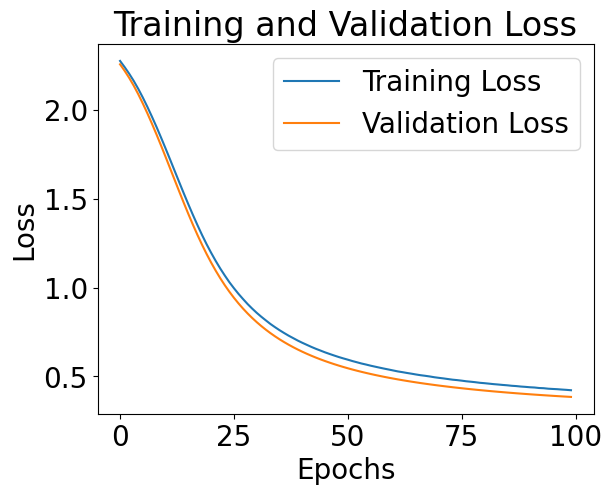

Learning Rate: 0.001, Validation Loss: 0.3840, Validation Error: 0.0991

Training with learning rate: 0.01
Epoch 2/100, Training Loss: 1.5583, Validation Loss: 1.2432, Validation Error: 0.2229
Epoch 3/100, Training Loss: 1.0686, Validation Loss: 0.8710, Validation Error: 0.1679
Epoch 4/100, Training Loss: 0.8069, Validation Loss: 0.6843, Validation Error: 0.1448
Epoch 5/100, Training Loss: 0.6687, Validation Loss: 0.5799, Validation Error: 0.1315
Epoch 6/100, Training Loss: 0.5863, Validation Loss: 0.5142, Validation Error: 0.1214
Epoch 7/100, Training Loss: 0.5311, Validation Loss: 0.4694, Validation Error: 0.1149
Epoch 8/100, Training Loss: 0.4918, Validation Loss: 0.4368, Validation Error: 0.1111
Epoch 9/100, Training Loss: 0.4620, Validation Loss: 0.4122, Validation Error: 0.1069
Epoch 10/100, Training Loss: 0.4390, Validation Loss: 0.3934, Validation Error: 0.1041
Epoch 12/100, Training Loss: 0.4063, Validation Loss: 0.3655, Validation Error: 0.0965
Epoch 13/100, Training Loss: 0.

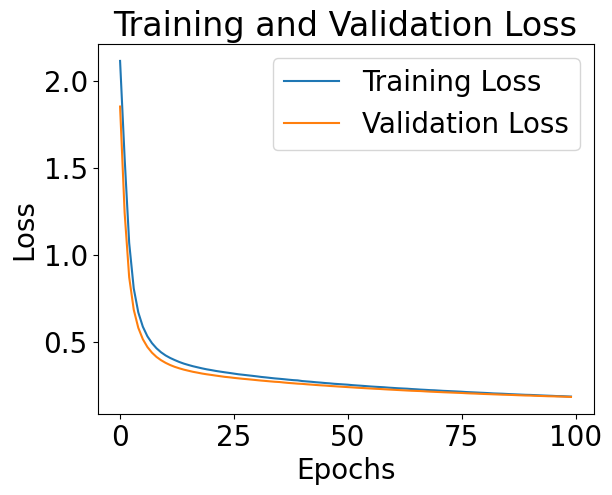

Learning Rate: 0.01, Validation Loss: 0.1819, Validation Error: 0.0506

Training with learning rate: 0.1
Epoch 2/100, Training Loss: 0.3799, Validation Loss: 0.3291, Validation Error: 0.0940
Epoch 3/100, Training Loss: 0.3276, Validation Loss: 0.2912, Validation Error: 0.0807
Epoch 4/100, Training Loss: 0.2992, Validation Loss: 0.2671, Validation Error: 0.0765
Epoch 5/100, Training Loss: 0.2759, Validation Loss: 0.2508, Validation Error: 0.0719
Epoch 6/100, Training Loss: 0.2574, Validation Loss: 0.2398, Validation Error: 0.0676
Epoch 7/100, Training Loss: 0.2403, Validation Loss: 0.2265, Validation Error: 0.0639
Epoch 8/100, Training Loss: 0.2263, Validation Loss: 0.2174, Validation Error: 0.0619
Epoch 9/100, Training Loss: 0.2131, Validation Loss: 0.2022, Validation Error: 0.0555
Epoch 10/100, Training Loss: 0.2016, Validation Loss: 0.1948, Validation Error: 0.0544
Epoch 12/100, Training Loss: 0.1817, Validation Loss: 0.1742, Validation Error: 0.0471
Epoch 13/100, Training Loss: 0.17

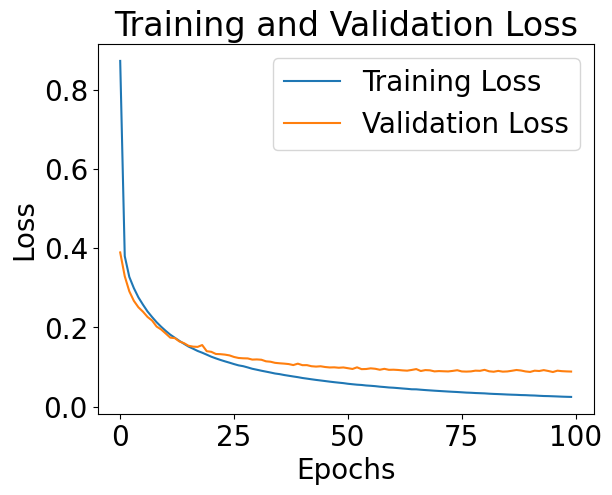

Learning Rate: 0.1, Validation Loss: 0.0886, Validation Error: 0.0246

Training with learning rate: 1
Epoch 2/100, Training Loss: 0.1935, Validation Loss: 0.1922, Validation Error: 0.0571
Epoch 3/100, Training Loss: 0.1510, Validation Loss: 0.1450, Validation Error: 0.0415
Epoch 4/100, Training Loss: 0.1274, Validation Loss: 0.1768, Validation Error: 0.0527
Epoch 5/100, Training Loss: 0.1105, Validation Loss: 0.1376, Validation Error: 0.0376
Epoch 6/100, Training Loss: 0.0975, Validation Loss: 0.1458, Validation Error: 0.0413
Epoch 7/100, Training Loss: 0.0858, Validation Loss: 0.1484, Validation Error: 0.0419
Epoch 8/100, Training Loss: 0.0801, Validation Loss: 0.1279, Validation Error: 0.0359
Epoch 9/100, Training Loss: 0.0723, Validation Loss: 0.1279, Validation Error: 0.0358
Epoch 10/100, Training Loss: 0.0660, Validation Loss: 0.1090, Validation Error: 0.0291
Epoch 12/100, Training Loss: 0.0567, Validation Loss: 0.1137, Validation Error: 0.0312
Epoch 13/100, Training Loss: 0.0522,

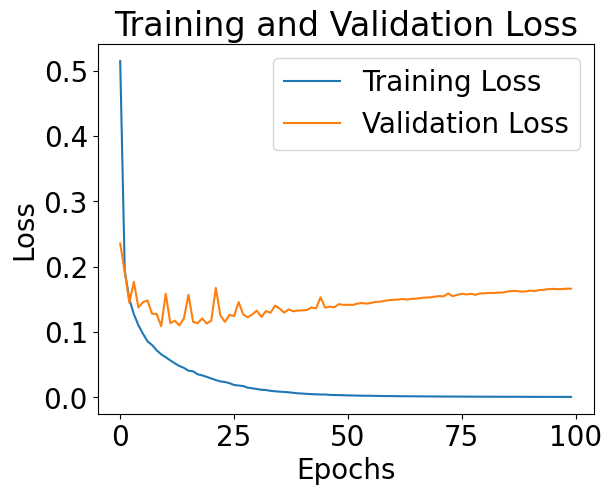

Learning Rate: 1, Validation Loss: 0.1664, Validation Error: 0.0280



In [10]:
from torch.utils.data import DataLoader, TensorDataset
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)

train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.Tensor(np.eye(10)[y_train]))
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val),torch.Tensor(np.eye(10)[y_val]))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(np.eye(10)[y_test]))

# Create DataLoaders
def create_dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=256):
  train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
  val_dataset = TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
  test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloader(x_train, y_train, x_val, y_val, x_test, y_test)

# Experiment with different learning rates
learning_rates = [0.001, 0.01, 0.1, 1]
num_epochs = 100

for learning_rate in learning_rates:
    print(f"Training with learning rate: {learning_rate}")

    trained_mlp = train_MLP_mnist(train_loader, val_loader, lr=learning_rate, num_epochs=num_epochs)

    val_loss, val_error = evaluate_MLP(trained_mlp, val_loader)
    print(f"Learning Rate: {learning_rate}, Validation Loss: {val_loss:.4f}, Validation Error: {val_error:.4f}\n")


#### 2b
Based on the loss curves, select the learning rate and number of epochs that minimizes the validation loss.  Retrain that model (if it's not stored), and report training loss, validation loss, training error, validation error, and test error.

Epoch 2/100, Training Loss: 0.3812, Validation Loss: 0.3136, Validation Error: 0.0865
Epoch 3/100, Training Loss: 0.3283, Validation Loss: 0.2936, Validation Error: 0.0861
Epoch 4/100, Training Loss: 0.3001, Validation Loss: 0.2655, Validation Error: 0.0752
Epoch 5/100, Training Loss: 0.2785, Validation Loss: 0.2518, Validation Error: 0.0708
Epoch 6/100, Training Loss: 0.2604, Validation Loss: 0.2369, Validation Error: 0.0662
Epoch 7/100, Training Loss: 0.2453, Validation Loss: 0.2234, Validation Error: 0.0621
Epoch 8/100, Training Loss: 0.2306, Validation Loss: 0.2146, Validation Error: 0.0595
Epoch 9/100, Training Loss: 0.2183, Validation Loss: 0.2041, Validation Error: 0.0557
Epoch 10/100, Training Loss: 0.2076, Validation Loss: 0.1957, Validation Error: 0.0535
Epoch 12/100, Training Loss: 0.1878, Validation Loss: 0.1819, Validation Error: 0.0502
Epoch 13/100, Training Loss: 0.1796, Validation Loss: 0.1738, Validation Error: 0.0479
Epoch 14/100, Training Loss: 0.1721, Validation Los

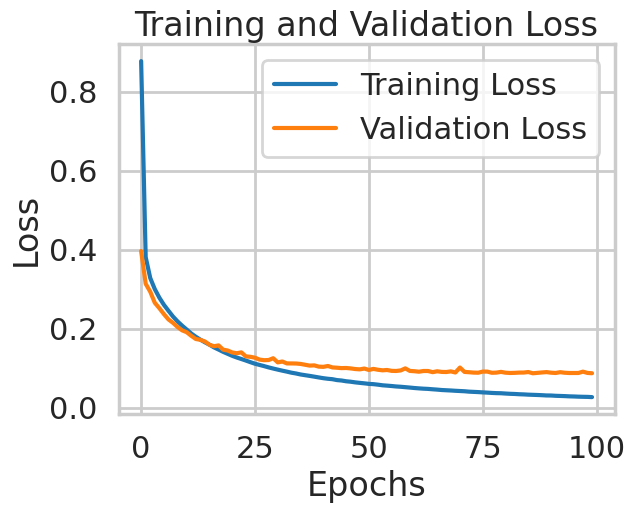

Final Training Loss: 0.0254
Final Validation Loss: 0.0871
Final Test Loss: 0.0796
Final Training Error: 0.47%
Final Validation Error: 2.53%
Final Test Error: 2.50%


In [17]:
# TO DO (retrain if needed, and evaluate model on train, val, and test sets)

# retrain if needed
trained_mlp = train_MLP_mnist(train_loader, val_loader, lr=0.1, num_epochs=100)

# evaluate model on train, val, and test sets
final_train_loss, final_train_error = evaluate_MLP(trained_mlp, train_loader)
final_val_loss, final_val_error = evaluate_MLP(trained_mlp, val_loader)
final_test_loss, final_test_error = evaluate_MLP(trained_mlp, test_loader)

# Report
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}")

print(f"Final Training Error: {(final_train_error * 100):.2f}%")
print(f"Final Validation Error: {(final_val_error * 100):.2f}%")
print(f"Final Test Error: {(final_test_error * 100):.2f}%")

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [2]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/MyDrive/CS441/24FA/hw4/" # TO DO: modify this to your directory
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))

Mounted at /content/gdrive/


#### 3a
Spend some time to visualize different pairs of features and their relationships to the species.  We’ve done one for you.  Include in your report at least two other visualizations.

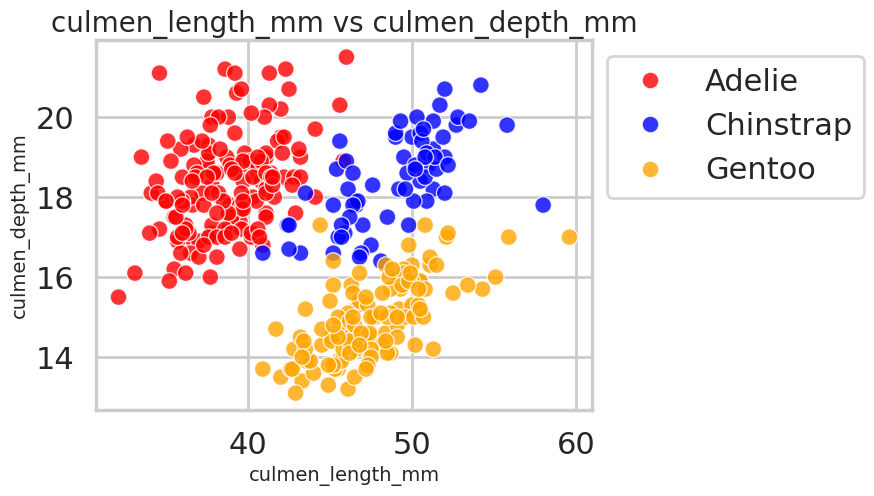

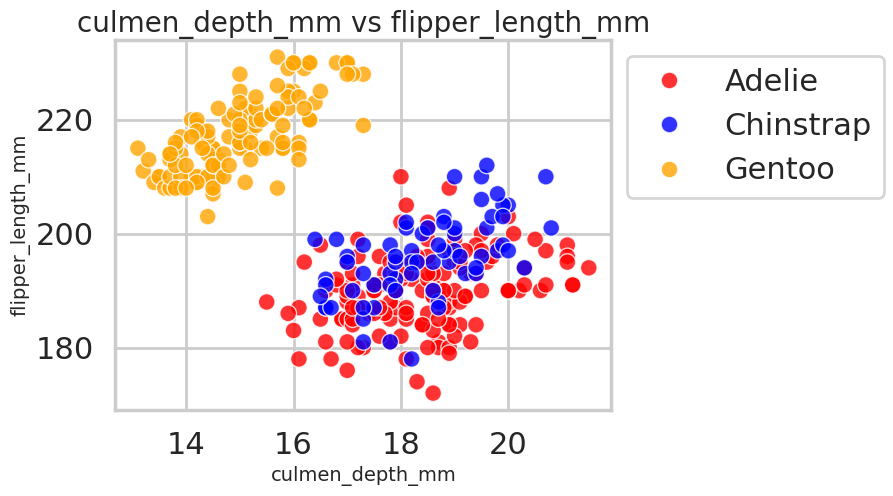

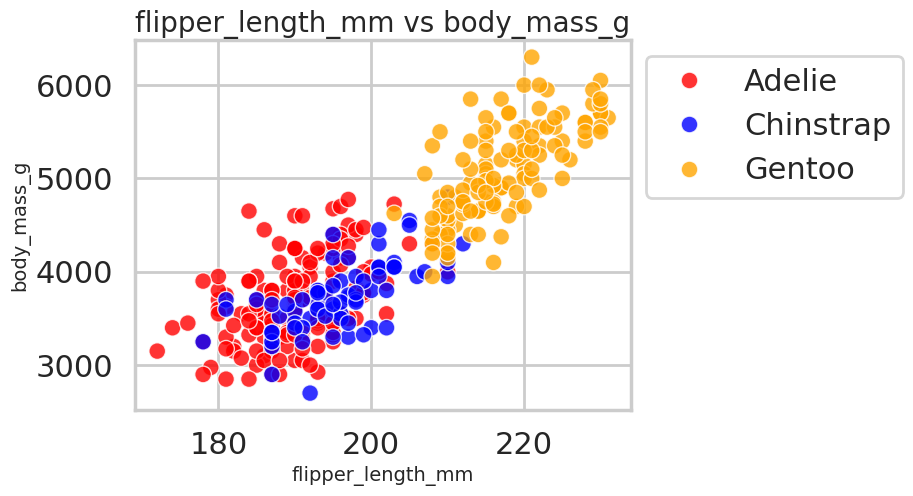

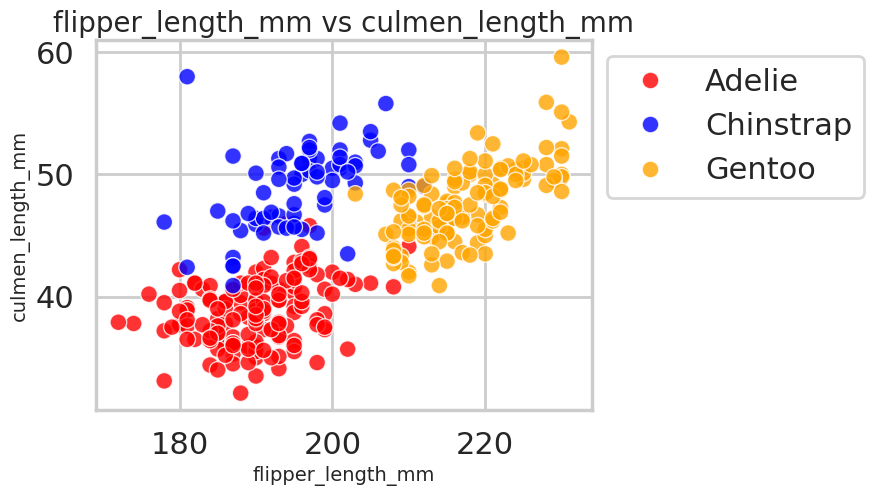

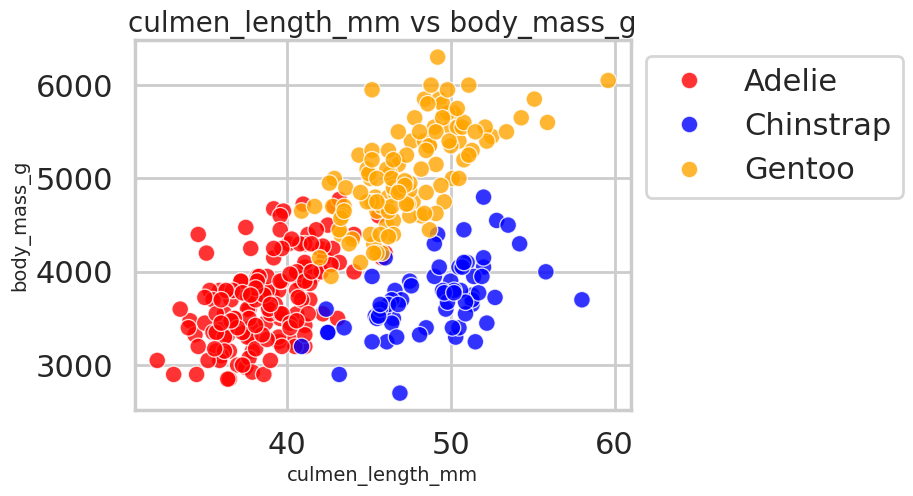

In [3]:
def plot_scatter(feature1, feature2):
  '''
  Provide names of two features to create a scatterplot of them
  E.g. plot_scatter('culmen_length_mm', 'culmen_depth_mm')
  Possible features: 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
  '''

  palette = ["red", "blue", "orange"]

  sns.scatterplot(data=df_penguins, x = feature1, y = feature2,
               hue = 'species', palette=palette, alpha=0.8)
  # Doc: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

  plt.xlabel(feature1, fontsize=14)
  plt.ylabel(feature2, fontsize=14)
  plt.title(feature1 + ' vs ' + feature2, fontsize=20)
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.show()

# TO DO call plot_scatter with different feature pairs to create some visualizations


plot_scatter('culmen_length_mm', 'culmen_depth_mm')

# Culmen Depth + Flipper Length
plot_scatter('culmen_depth_mm', 'flipper_length_mm')
# Flipper Length + Body Mass
plot_scatter('flipper_length_mm', 'body_mass_g')
# Flipper Length + Culmen Length
plot_scatter('flipper_length_mm', 'culmen_length_mm')

plot_scatter('culmen_length_mm', 'body_mass_g')



#### 3b
Suppose you want to be able to identify the Gentoo species with a simple rule with very high accuracy.  Use a decision tree classifier to figure out such a rule that has only two checks (e.g. “mass greater than 4000 g, and culmen length less than 40 mm is Gentoo; otherwise, not”).   You can use the library DecisionTreeClassifier with either ‘gini’ or ‘entropy’ criterion. Use sklearn.tree.plot_tree with feature_names and class_names arguments to visualize the decision tree.  Include the tree that you used to find the rule in your report and the rule.

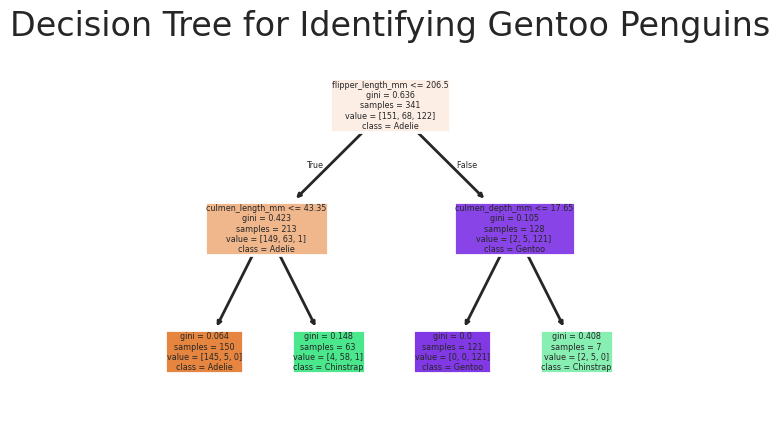

Gentoo Precision: 121/121
Gentoo Recall: 121/122


In [4]:
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Prepare the data
X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# Create and fit the classifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)
tree_clf.fit(X, y)

# Plot the tree
plot_tree(tree_clf, feature_names=feature_names, class_names=class_names, filled=True)
plt.title("Decision Tree for Identifying Gentoo Penguins")
plt.show()

# Predict on the training data to evaluate the rule's effectiveness
y_pred = tree_clf.predict(X)

cm = confusion_matrix(y, y_pred, labels=class_names)


gentoo_index = np.where(class_names == 'Gentoo')[0][0]
TP = cm[gentoo_index, gentoo_index]
FN = cm[gentoo_index, :].sum() - TP
print(f'Gentoo Precision: {TP}/{TP + (cm[:, gentoo_index].sum() - TP)}')
print(f'Gentoo Recall: {TP}/{TP + FN}')

#### 3c

Use any method at your disposal to achieve maximum 5-fold cross-validation accuracy on this problem. To keep it simple, we will use sklearn.model_selection to perform the cross-validation for us. Report your model design and 5-fold accuracy.  It is possible to get more than 99% accuracy.

In [26]:
# design a classification model, import libraries as needed
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# TO DO -- choose some model and fit the data
model = RandomForestClassifier(n_estimators=100, random_state=0)
# model = HistGradientBoostingClassifier(learning_rate = 0.01, max_iter = 100, random_state=0)
# model = DecisionTreeClassifier(max_depth=10, random_state=0)

scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}%'.format(scores.mean() * 100))

CV Accuracy: 99.11764705882354%


## Part 4: Stretch Goals
Include any new code needed for Part 4 here

## Part 4b: Find a second simple rule to identify Gentoo

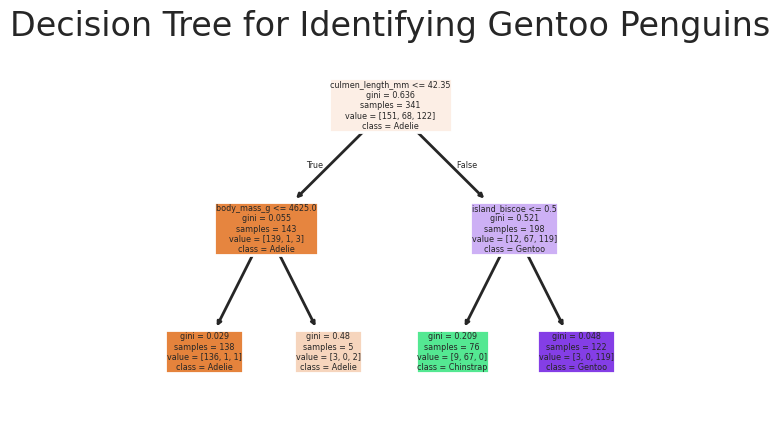

Gentoo Precision: 119/122
Gentoo Recall: 119/122


In [30]:
# TO DO (optional)

# Plot the tree

feature_names_copy = [f for f in feature_names if (f != 'flipper_length_mm' and f != 'culmen_depth_mm')]
X_copy = X[[f for f in feature_names if (f != 'flipper_length_mm' and f != 'culmen_depth_mm')]]
tree_clf.fit(X_copy, y)

plot_tree(tree_clf, feature_names=feature_names_copy, class_names=class_names, filled=True)
plt.title("Decision Tree for Identifying Gentoo Penguins")
plt.show()

# Predict on the training data to evaluate the rule's effectiveness
y_pred = tree_clf.predict(X_copy)

cm = confusion_matrix(y, y_pred, labels=class_names)


gentoo_index = np.where(class_names == 'Gentoo')[0][0]
TP = cm[gentoo_index, gentoo_index]
FN = cm[gentoo_index, :].sum() - TP
print(f'Gentoo Precision: {TP}/{TP + (cm[:, gentoo_index].sum() - TP)}')
print(f'Gentoo Recall: {TP}/{TP + FN}')

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24FA/hw4" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_FA24_HW4_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")